# Minimal Spanning Tree - painter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
from IPython.display import display

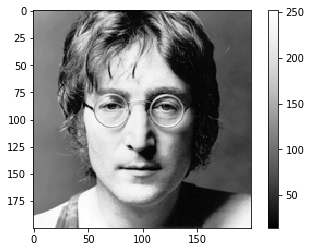

In [15]:
def loadImage(fileName, targetSize=(100,200)):
    """Load and downsample animage"""
    im = Image.open(fileName)
    im.thumbnail(targetSize, Image.ANTIALIAS)
    im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    return im

img = loadImage('../../photo.jpg' , (200,400))
plt.imshow(img, cmap="Greys_r"); # Reverse, to have black as low (default is to have white as low)
plt.colorbar();

In [18]:
def image_to_data(im):
    y = np.array(im)
    (h,w) = y.shape
    y = np.mean(y.reshape((h*w,1)), axis=1)
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    x[:,1] = 1-x[:,1]
    return (x,y)

imgxy, imgz = image_to_data(img)

In [21]:
def sample_points(xy, z, n=1):
    p = np.max(z)-z
    p = p/np.sum(p)
    out = xy[np.random.choice(list(range(xy.shape[0])), p=p, size=n),:]
    if n==1:
        out = out[0]
    #print(out)
    return out
    
sample_points(imgxy, imgz, n=1)

array([0.89, 0.11])

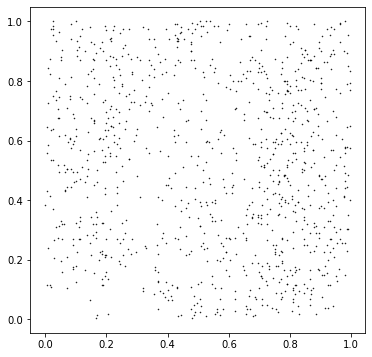

In [148]:
np.random.seed(1)
points = sample_points(imgxy, imgz, 100)
plt.figure(figsize=(6,6))
plt.plot(points[:,0], points[:,1], 'k.', markersize=1);

In [129]:
def eplot(points, edges):
    for e in edges:
        plt.plot(points[[e[0],e[1]],0], points[[e[0],e[1]],1], 'k-')

#eplot(points,[(1,2),(2,3),(3,4)])

In [130]:
def mst_bf(points):
    """Build a minimally spanning tree. Brute-force N2 solution; very slow."""
    n = points.shape[0]
    dist = np.zeros((n,n))
    for i in range(n):
        dist[i,:] = np.sqrt(np.square(points[i,0]-points[:,0])+np.square(points[i,1]-points[:,1]))
    inf = np.max(dist)
    taken = set([0])
    remaining = list(range(1,n))
    count = 1
    edges = []
    while len(remaining)>0:
        best = (inf,0,0)
        for i in taken:
            for j in remaining:
                if dist[i,j]<best[0]:
                    best = (dist[i,j],i,j)
        _,i,j = best
        edges.append((i,j))
        taken.add(j)
        remaining.remove(j)
    return edges

In [131]:
class PQ:
    """Priority queue"""
    def __init__(self):
        self.x = [None]
        
    def add(self, key, val):
        self.x.append((key,val))
        self._swim(len(self.x)-1)
        
    def n(self):
        return len(self.x)-1
        
    def pop(self):
        if len(self.x)==1: return None
        out = self.x[1]
        self.x[1] = self.x[-1]
        self.x.pop(-1)
        self._sink(1)
        return out[1]
    
    def _swap(self,i,j):
        self.x[i],self.x[j] = self.x[j],self.x[i]
    
    def _swim(self, i):
        if i==1: return
        if self.x[i//2]>self.x[i]:
            self._swap(i//2, i)
            self._swim(i//2)
            
    def _sink(self, i):
        if i*2 < len(self.x) and self.x[i]>self.x[2*i]:
            self._swap(i, 2*i)
            self._sink(2*i)
        if i*2+1 < len(self.x) and self.x[i]>self.x[2*i+1]:
            self._swap(i, 2*i+1)
            self._sink(2*i+1)
            
q = PQ()
for i in [4,2,3,1,5]:
    q.add(i,i)
print(q.x)
while q.n()>0:
    print(q.pop())

[None, (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
1
2
3
4
5


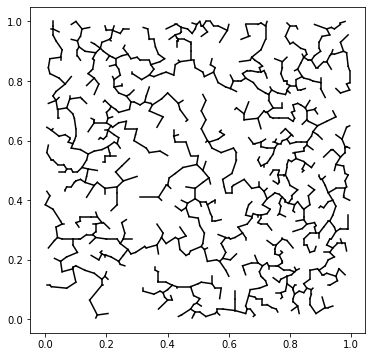

In [149]:
def mst(points):
    """Build a minimally spanning tree. Brute-force N2 solution; very slow."""
    n = points.shape[0]
    dist = np.zeros((n,n))
    for i in range(n):
        dist[i,:] = np.sqrt(np.square(points[i,0]-points[:,0])+np.square(points[i,1]-points[:,1]))
    inf = np.max(dist)
    taken = set([0])
    remaining = list(range(1,n))
    count = 1
    edges = []
    q = PQ()
    newnode = 0 # Node currently considered
    while len(remaining)>0:
        for j in remaining: # First update the queue
            q.add(dist[newnode,j], (newnode,j))
        while newnode in taken:
            oldnode,newnode = q.pop()
        remaining.remove(newnode)
        edges.append((oldnode,newnode))
        taken.add(newnode)
    return edges

fig = plt.figure(figsize=(6,6))
#plt.subplot(121)
#edges = mst_bf(points)
#eplot(points, edges)
#plt.subplot(122)
%prun edges = mst(points)
eplot(points, edges)

All ideas below are stupid. The only thing that I need to do really is to triangulate, so that only edges betwen nearby vertices are considered. Learn to triangulate! Or use vicinities - that's even better. UMAP-style. Each vertex should be connected to all vertices within a range, or 3 closest vertices, whichever is  more stringent requirement.

Is it possible to add new distances not to the end, but in the middle, looking for the first distance that is no longer relevant? (to element already in a tree)

Or can we somehow group elements, and only go through groups that are relevant?

Or any other cool ways to clear the queue eagerly?

Or exclude distances to elements that are surrounded?